In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import  classification_report
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import shap

c:\Users\jctor\OneDrive\Escritorio\prueba_ds\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("C:/Users/jctor/OneDrive/Escritorio/prueba_ds/data/muestra.csv")
print(df.shape)
df.head()

(322712, 17)


,Unnamed: 0,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,freno_brusco,aceleracion_fuerte,giro_inesperado,toma_hueco,prob_accidente
0,97973,171798691863,3.931,357.000000,-0.349564,9.622590,0.031126,0.036720,-0.013416,-0.028469,509.0,0.000000,0,0,0,0,0
1,404710,1047972020277,6.000,178.271930,1.216292,7.755056,0.828419,0.065474,-0.019547,0.007330,1104.0,19.102821,0,0,0,0,0
2,409767,386547056816,3.900,75.000000,-0.375901,9.213169,-0.198725,-0.048817,-0.063093,0.080381,987.0,22.257120,0,0,0,0,0
3,1124496,335007449247,4.000,217.533478,-1.181934,-6.971075,-5.221353,0.054250,-0.009374,0.064610,81.0,3.853949,0,0,0,0,0
4,922101,764504178819,5.432,315.000000,0.562655,8.633755,2.588211,0.062792,-0.246887,0.045682,478.0,0.000000,0,0,0,0,0


In [5]:
datos_modelo = df[['bookingID','Speed','acceleration_z','Bearing','acceleration_y','Accuracy','acceleration_x','prob_accidente']]
print(datos_modelo.shape)
datos_modelo.head()

(322712, 8)


,bookingID,Speed,acceleration_z,Bearing,acceleration_y,Accuracy,acceleration_x,prob_accidente
0,171798691863,0.000000,0.031126,357.000000,9.622590,3.931,-0.349564,0
1,1047972020277,19.102821,0.828419,178.271930,7.755056,6.000,1.216292,0
2,386547056816,22.257120,-0.198725,75.000000,9.213169,3.900,-0.375901,0
3,335007449247,3.853949,-5.221353,217.533478,-6.971075,4.000,-1.181934,0
4,764504178819,0.000000,2.588211,315.000000,8.633755,5.432,0.562655,0


In [6]:
datos_modelo .prob_accidente.value_counts(normalize=True )

prob_accidente
0    0.715508
1    0.284492
Name: proportion, dtype: float64

In [14]:


df_muestra_10, _ = train_test_split(
    datos_modelo,
    test_size=0.9,
    stratify=datos_modelo['prob_accidente'],
    random_state=42
)


In [16]:
print("Original:")
print(datos_modelo['prob_accidente'].value_counts(normalize=True))

print("\nMuestra 10%:")
print(df_muestra_10['prob_accidente'].value_counts(normalize=True))


Original:
prob_accidente
0    0.715508
1    0.284492
Name: proportion, dtype: float64

Muestra 10%:
prob_accidente
0    0.715503
1    0.284497
Name: proportion, dtype: float64


### Entrenamiento del modelo

In [17]:
target = "prob_accidente"   
X = df_muestra_10.drop(columns=[target])
y = df_muestra_10[target]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Modelo: Logistic Regression


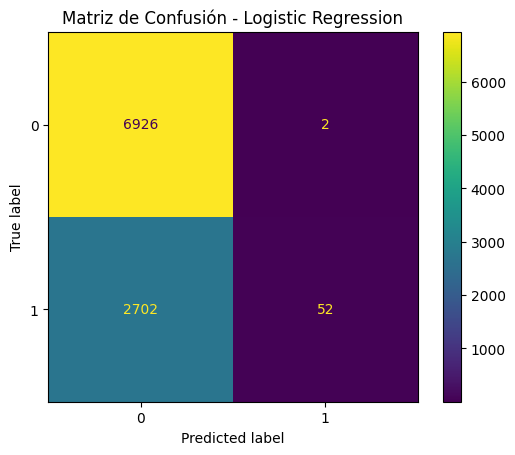

Modelo: Random Forest


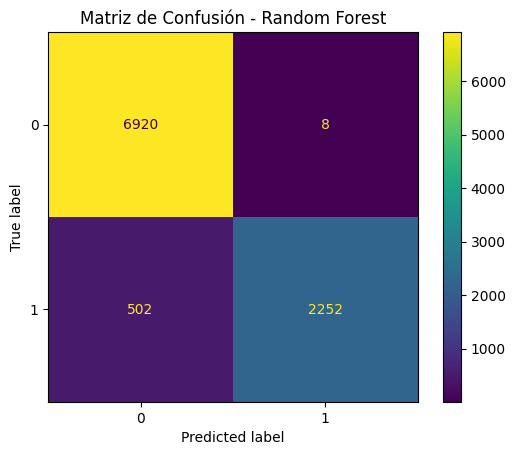

Modelo: XGBoost


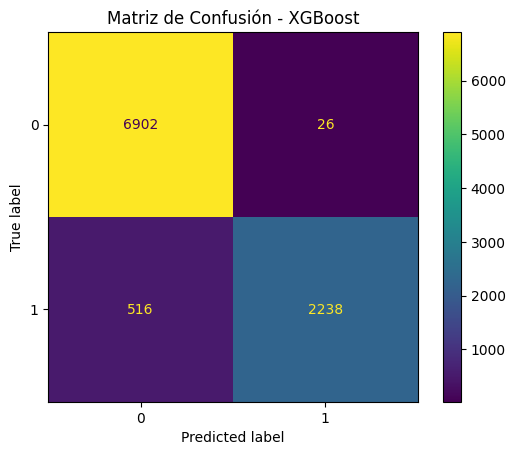

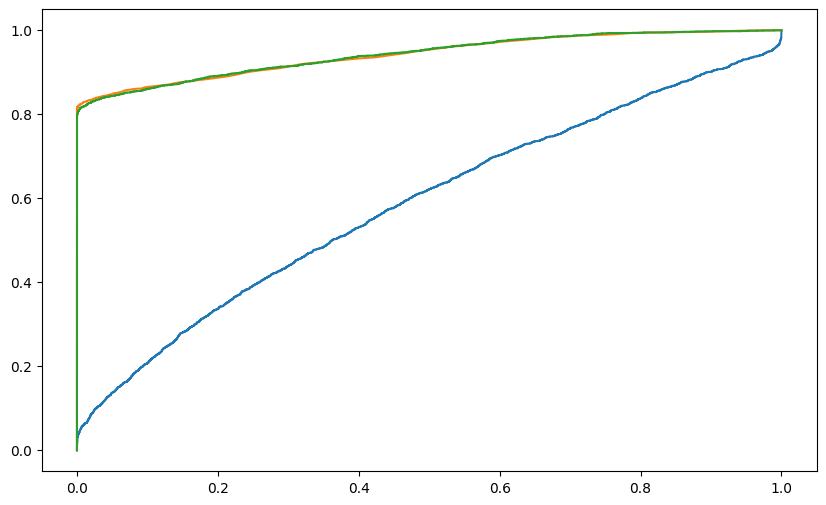

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )
}


y_pred_probas = {}

# ========================================
# 7. Entrenar modelos y mostrar matriz de confusión
# ========================================
for name, model in models.items():
    print("="*60)
    print(f"Modelo: {name}")
    print("="*60)
    
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Guardar probabilidades para ROC
    y_pred_probas[name] = y_pred_proba
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matriz de Confusión - {name}")
    plt.show()

# ========================================
# 8. Curva ROC de los 3 modelos
# ========================================
plt.figure(figsize=(10,6))

for name, y_pred_proba in y_pred_probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")



=========== EVALUACIÓN DE MODELOS ===========

Modelo: Logistic Regression

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      6928
           1       0.96      0.02      0.04      2754

    accuracy                           0.72      9682
   macro avg       0.84      0.51      0.44      9682
weighted avg       0.79      0.72      0.61      9682



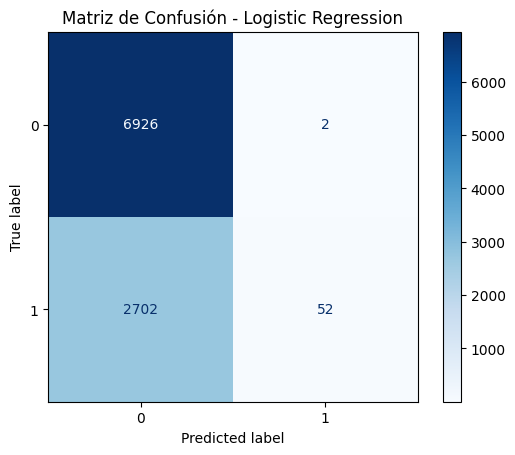

Modelo: Random Forest

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      6928
           1       1.00      0.82      0.90      2754

    accuracy                           0.95      9682
   macro avg       0.96      0.91      0.93      9682
weighted avg       0.95      0.95      0.95      9682



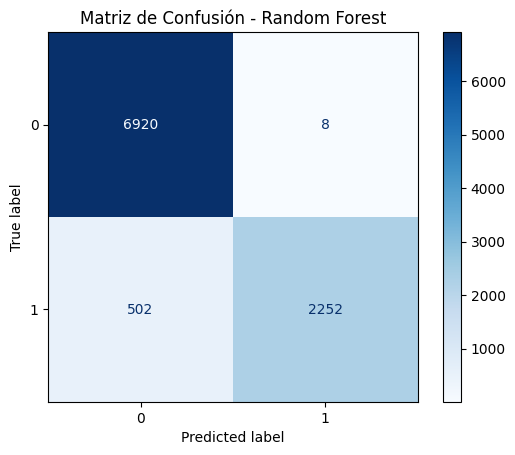

Modelo: XGBoost

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      6928
           1       0.99      0.81      0.89      2754

    accuracy                           0.94      9682
   macro avg       0.96      0.90      0.93      9682
weighted avg       0.95      0.94      0.94      9682



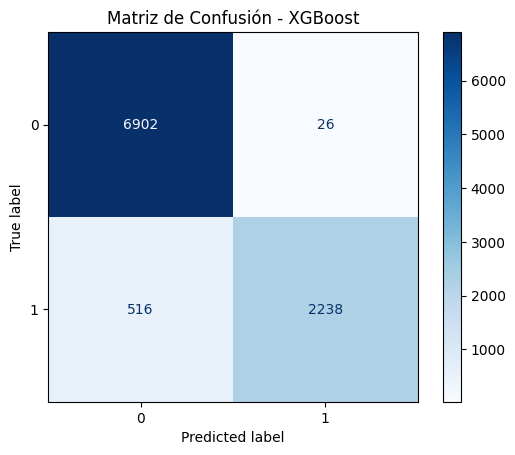

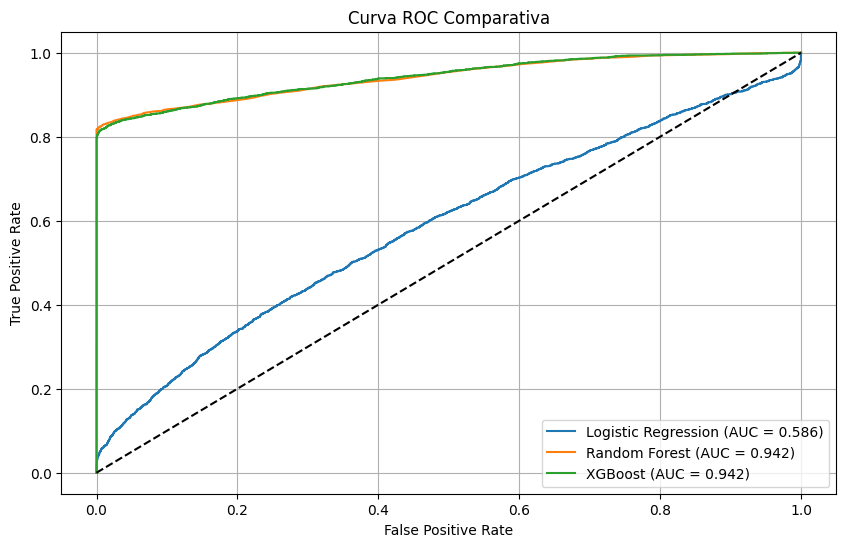


=========== RESUMEN GLOBAL DE MÉTRICAS ===========



,Accuracy,Precision,Recall,F1-score,AUC
Logistic Regression,0.720719,0.962963,0.018882,0.037037,0.586109
Random Forest,0.947325,0.996460,0.817720,0.898285,0.941834
XGBoost,0.944020,0.988516,0.812636,0.891989,0.942263


In [27]:
metricas_modelos = {}

print("\n=========== EVALUACIÓN DE MODELOS ===========\n")

for name, model in models.items():
    print("="*70)
    print(f"Modelo: {name}")
    print("="*70)

    # Logistic Regression usa datos escalados
    if name == "Logistic Regression":
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Guardar para curva ROC
    y_pred_probas[name] = y_pred_proba

    # ==========================
    #     MÉTRICAS NUMÉRICAS
    # ==========================
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba)

    metricas_modelos[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "AUC": auc
    }

    # Reporte completo
    print("\n📌 Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # ==========================
    #     MATRIZ DE CONFUSIÓN
    # ==========================
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {name}")
    plt.show()

# ==========================
#     CURVA ROC FINAL
# ==========================
plt.figure(figsize=(10,6))

for name, y_pred_proba in y_pred_probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("Curva ROC Comparativa")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

# ==========================
#     TABLA FINAL
# ==========================
print("\n=========== RESUMEN GLOBAL DE MÉTRICAS ===========\n")

import pandas as pd
df_metricas = pd.DataFrame(metricas_modelos).T
display(df_metricas)

### Resultados:
* se obtuvieron muy buenos resultados con modelos como random forest y XGBoost 
* Se observa overfitting en ambos modelos , dado que el Recall está dando 1
* Se hará ajuste de parametros para el modelo XGBoost , esperando encontrar mejores resultados

In [ ]:
xgb_tuned = xgb.XGBClassifier(
    n_estimators=250,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=20,     
    gamma=10,                
    reg_alpha=5,              
    reg_lambda=25,           
    scale_pos_weight=2.51,    
    eval_metric="logloss",
    random_state=42
)

xgb_tuned.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)




,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'



📌 Nuevas métricas del XGBoost Regularizado
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6928
           1       0.98      0.82      0.89      2754

    accuracy                           0.94      9682
   macro avg       0.95      0.90      0.93      9682
weighted avg       0.94      0.94      0.94      9682



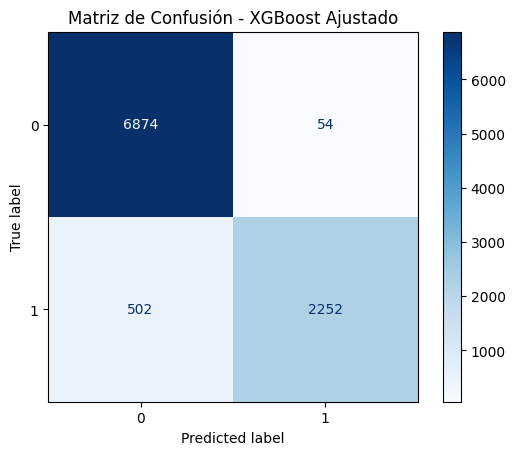

In [49]:
y_pred = xgb_tuned.predict(X_test)
y_pred_proba = xgb_tuned.predict_proba(X_test)[:, 1]

print("\n📌 Nuevas métricas del XGBoost Regularizado")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - XGBoost Ajustado")
plt.show()


In [54]:

scoring = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

# Validación cruzada
cv_results = cross_validate(
    xgb_tuned,
    X_train,
    y_train,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

# Mostrar resultados
print("===== RESULTADOS CV (5 FOLDS) =====\n")

print("Precision por fold:", cv_results["test_precision"])
print("Precision promedio:", cv_results["test_precision"].mean())
print()

print("Recall por fold:", cv_results["test_recall"])
print("Recall promedio:", cv_results["test_recall"].mean())
print()

print("F1 por fold:", cv_results["test_f1"])
print("F1 promedio:", cv_results["test_f1"].mean())
print()

print("ROC-AUC por fold:", cv_results["test_roc_auc"])
print("ROC-AUC promedio:", cv_results["test_roc_auc"].mean())
print("ROC-AUC desviación estándar:", cv_results["test_roc_auc"].std())


===== RESULTADOS CV (5 FOLDS) =====

Precision por fold: [0.98151571 0.99175069 0.97693727 0.97844424 0.97759104]
Precision promedio: 0.9812477882102538

Recall por fold: [0.82645914 0.84202335 0.82348367 0.8118196  0.81478599]
Recall promedio: 0.8237143496862348

F1 por fold: [0.8973384  0.91077441 0.89367089 0.88737782 0.88879457]
F1 promedio: 0.895591216501923

ROC-AUC por fold: [0.94346158 0.94609794 0.94814082 0.93132102 0.9374988 ]
ROC-AUC promedio: 0.9413040314432513
ROC-AUC desviación estándar: 0.00614033382462617


### Resultaoos Finales:
* Se implementaron tres modelos de clasificación para predecir la probabilidad de accidente, logrando desempeños adecuados en las métricas evaluadas.

* El modelo XGBoost obtuvo los mejores resultados en la matriz de confusión, por lo que se selecciona como la solución óptima.

* Se realizó un ajuste de hiperparámetros (tuning) sobre XGBoost, encontrando una configuración que mejora específicamente la métrica de recall para la clase de mayor interés.

* El modelo final de XGBoost cuenta con el desempeño y estabilidad necesarios para ser llevado a producción y evaluar su comportamiento con datos nuevos.

### Analsisi de variables de importancia
Con este analisis se revisarán las variables que mejor explican la variable respuesta.

In [57]:
explainer = shap.TreeExplainer(xgb_tuned)
X_sample = X_test.sample(1000, random_state=42)

shap_values = explainer.shap_values(X_sample)

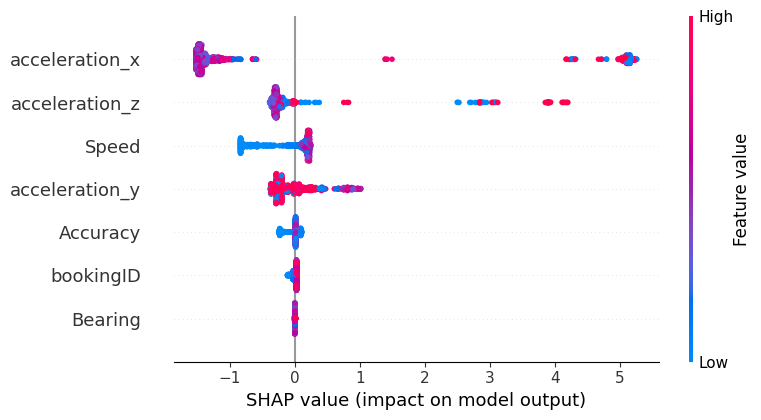

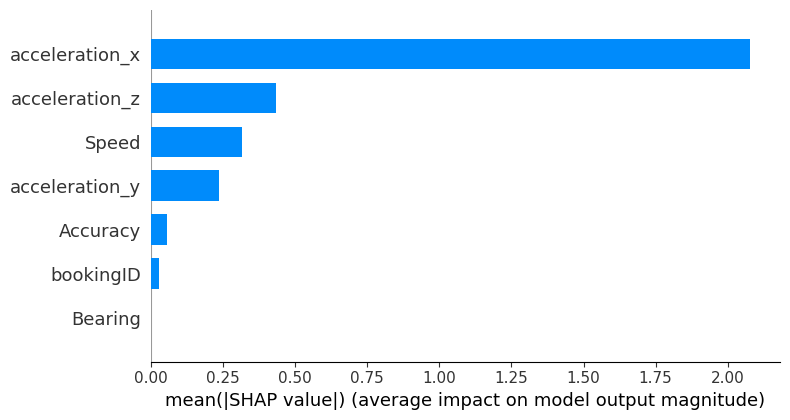

In [58]:
shap.summary_plot(shap_values, X_sample)
shap.summary_plot(shap_values, X_sample, plot_type="bar")